# **Exercise Sheet 5: Classification**

# Part A: Foundations & Concepts

Before you start coding and building classification models, take some time to consider the key concepts and motivations behind classification techniques.

Reflect on these ideas independently before turning to ChatGPT or other resources for help. Discussing your thoughts with classmates is also highly encouraged!

## 1. General Concepts

### a) What type of outcome do you have in a classification task and how is this different from regression task?

#### Your Answer:

#### Solution:
- Classification: Outcome is categorical (e.g., disease vs no disease)
- Regression: Outcome is continuous (e.g., predicting insulin levels)

### b) What is the difference between an explanatory and prediction (classification) logistic regression model?

#### Your Answer:

#### Solution:
- Explanatory: 
    - Focuses on understanding the relationship between predictors and outcome, to explain the outcome.
    - Focus on interpretability
    - Use all data to fit a model and interpret coefficients and p-values.
- Prediction:
    - Focuses on predicting the outcome, not necessarily understanding the relationship. 
    - Try to build a model that generalizes well to new data. 
    - Use accuracy, confusion matrix, cross-validation to evalute the performance

### c) Which metrics are used to evaluate a classification model?
Briefly explain each metric that we have covered in the lecture.

#### Your Answer:

#### Solution:
- Accuracy: The proportion of correct predictions out of all predictions made.
- ROC curve: A graphical representation of the true positive rate (sensitivity) against the false positive rate (1-specificity) at various threshold settings.
- Confusion matrix: Summarizes performance by showing the counts of true positives, true negatives, false positives, and false negatives.
- Note there are more like precision, recall, F1-score, etc. Great job if you mentioned those!

### d) How do you get a prediction from the output of a Logistic regression?
- Logistic regression predicts the probability of having outcome = category 1. This is a continuous value between 0 and 1. 
- How do you convert this into a predicted category?

#### Your Answer:

#### Solution:
- Usually we choose a threshold (e.g., 0.5) to classify the outcome.
- So if the predicted probability is greater than 0.5, we classify it as category 1, otherwise as category 0.

### e) How does KNN classification work? Briefly describe the concept.

#### Your Answer:

#### Solution:
KNN works as follows for a data point:
1. Find the k nearest neighbors based on a distance metric (e.g., Euclidean distance)
2. Find the most common class among these neighbors
3. Assign the class to the data point based on the majority vote

*Important:* KNN does not learn a model of the data but rather remembers the data and uses it for classification.

### f) How does SVM classification work? Briefly describe the concept.

#### Your Answer:

#### Solution:
SVM tries to find a seperation line between classes that maximizes the *margin* between the classes. You can control the number of 'acceptable misclassifications' by adjusting the C parameter. 

### g) How do you choose the parameters of the models?
- In KNN, we have to choose a vlue of the parameter k. 
- In SVM, we have to choose a value of the parameter C and what kernel to use.
- Are there general strategies?

#### Your Answer:

#### Solution:
There is no straight-forward way to choose the parameters of the models, as they heavily depend on the data and the problem at hand. However, common strategies include:
- Cross-validation: Gives a robust estimation of the model's performance for a given set of parameters.
- Grid search: Explore all (or a subset of) combinations of parameters to find the best one.

In practice this could look like:
- For KNN, you might try different values of k (e.g., 1 to 5), perform cross-validation for each k, and select the one with the best performance.
- For SVM, you might do a grid search with all combinations of C values (0.1, 0.5, 1) and kernel types (e.g., linear and radial) and evaluate their performance using cross-validation. In this example we would test 6 different models (2 kernels * 3 C values = 6 models) and choose the one with the best performance.

# Part B: Coding & Visualization

Now let's put our understanding of classification algorithms into practice! We'll begin by importing the necessary libraries.

Hint: You may find the provided helper functions useful for some tasks, but you are welcome to write your own code as well.

## Notes:
- task 2 currently supports One-Hot encoding or Gower. I'd suggest to choose one
- Dataset in task 2 is simulated and unbalanced and does not give super satisfying answers
- Visualizing the decision boundary of SVM in high-dimensions is not possible, so we just visualize the data and color them based on prediction
- TODO: There's an issue somewhere here because the ridge regression coefficents are the same for all features
- I used the sahd dataset, which works good imo, the thiomon is probably to big for this task


In [152]:
# Standard Libraries
import pandas as pd
import numpy as np
import warnings

# Scikit-learn: Data Processing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scikit-learn: Models and Metrics
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt

# UMAP for dimensionality reduction
from umap import UMAP

# Helper Functions
from helper import (
    simple_feature_importance,
    coef_feature_importance,
    evaluate_confusion_matrix,
    evaluate_roc,
    plot_projection
)

import gower

pd.set_option('display.float_format', '{:.4f}'.format)
warnings.filterwarnings("ignore")

## 2. KNN

### a) Load the dataset `todo.csv` and explore it.
- What outcome do you want to predict?
- What predictors do you want to use?

In [153]:
# Student Code

In [154]:
import numpy as np
import pandas as pd

# Simulate Dataset about Autoimmune Hepatitis (optimized for ~80% KNN accuracy)
np.random.seed(42)
n = 400

# Create moderately separated clusters
n_positive = int(0.4 * n)

# Positive cases - elevated but with more overlap
pos_age = np.random.normal(40, 12, n_positive)
pos_alt = np.random.normal(85, 25, n_positive)
pos_ast = np.random.normal(80, 28, n_positive)
pos_igg = np.random.normal(17, 4, n_positive)

# Negative cases - normal range but with some overlap
neg_age = np.random.normal(50, 15, n - n_positive)
neg_alt = np.random.normal(45, 20, n - n_positive)
neg_ast = np.random.normal(50, 22, n - n_positive)
neg_igg = np.random.normal(13, 3, n - n_positive)

# Combine and add noise
age = np.concatenate([pos_age, neg_age]) + np.random.normal(0, 3, n)
alt = np.concatenate([pos_alt, neg_alt]) + np.random.normal(0, 8, n)
ast = np.concatenate([pos_ast, neg_ast]) + np.random.normal(0, 8, n)
igg = np.concatenate([pos_igg, neg_igg]) + np.random.normal(0, 1.5, n)

# Clip to realistic ranges
age = np.clip(age, 18, 80).astype(int)
alt = np.clip(alt, 15, 150)
ast = np.clip(ast, 15, 150)
igg = np.clip(igg, 8, 25)

# Categorical variables with moderate correlation
sex = (['female'] * int(0.65 * n_positive) + ['male'] * (n_positive - int(0.65 * n_positive)) +
       ['female'] * int(0.45 * (n - n_positive)) + ['male'] * ((n - n_positive) - int(0.45 * (n - n_positive))))

family_autoimmune = (['yes'] * int(0.55 * n_positive) + ['no'] * (n_positive - int(0.55 * n_positive)) +
                     ['yes'] * int(0.25 * (n - n_positive)) + ['no'] * ((n - n_positive) - int(0.25 * (n - n_positive))))

alcohol = np.random.choice(['none', 'moderate', 'heavy'], n, p=[0.6, 0.3, 0.1])
ethnicity = np.random.choice(['white', 'black', 'asian', 'other'], n, p=[0.5, 0.2, 0.2, 0.1])

# Create target variable
autoimmune_hepatitis = np.concatenate([np.ones(n_positive), np.zeros(n - n_positive)])

# Shuffle everything
indices = np.random.permutation(n)
df = pd.DataFrame({
    'age': age[indices],
    'ALT': alt[indices],
    'AST': ast[indices],
    'IgG': igg[indices],
    'sex': np.array(sex)[indices],
    'alcohol': alcohol[indices],
    'family_autoimmune': np.array(family_autoimmune)[indices],
    'ethnicity': ethnicity[indices],
    'autoimmune_hepatitis': autoimmune_hepatitis[indices].astype(int)
})


In [155]:
# Solution
# df = pd.read_csv("todo.csv")

In [156]:
print(df.shape)
df.head()

(400, 9)


,age,ALT,AST,IgG,sex,alcohol,family_autoimmune,ethnicity,autoimmune_hepatitis
0,59,15.0000,41.4137,15.7421,male,none,no,white,0
1,49,26.4168,29.0177,9.1691,male,moderate,no,other,0
2,33,109.3997,62.1722,16.4275,female,moderate,yes,white,1
3,67,60.8053,27.5458,19.4710,male,none,no,white,0
4,35,55.3286,79.2527,21.0800,female,heavy,no,white,1


In [157]:
# Check the features and outcomes
print("Features:")
print(df.columns.tolist())

Features:
['age', 'ALT', 'AST', 'IgG', 'sex', 'alcohol', 'family_autoimmune', 'ethnicity', 'autoimmune_hepatitis']


In [158]:
# Check for categorical features and their values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   400 non-null    int64  
 1   ALT                   400 non-null    float64
 2   AST                   400 non-null    float64
 3   IgG                   400 non-null    float64
 4   sex                   400 non-null    object 
 5   alcohol               400 non-null    object 
 6   family_autoimmune     400 non-null    object 
 7   ethnicity             400 non-null    object 
 8   autoimmune_hepatitis  400 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 28.3+ KB
None


In [159]:
# Get unique values for categorical features
for col in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in sex: ['male' 'female']
Unique values in alcohol: ['none' 'moderate' 'heavy']
Unique values in family_autoimmune: ['no' 'yes']
Unique values in ethnicity: ['white' 'other' 'black' 'asian']


In [160]:
# Prepare data for modeling
X = df.drop(columns=["autoimmune_hepatitis"])
y = df["autoimmune_hepatitis"]

### b) To include categorical variables in KNN, perform One-Hot Encoding on the categorical variables. 

*Hint:* You can use the `pd.get_dummies()` function from pandas to perform One-Hot Encoding.

In [161]:
# Student Code

In [162]:
# One-hot encode categorical features
X = pd.get_dummies(X)
print(X.head())

   age      ALT     AST     IgG  sex_female  sex_male  alcohol_heavy  \
0   59  15.0000 41.4137 15.7421       False      True          False   
1   49  26.4168 29.0177  9.1691       False      True          False   
2   33 109.3997 62.1722 16.4275        True     False          False   
3   67  60.8053 27.5458 19.4710       False      True          False   
4   35  55.3286 79.2527 21.0800        True     False           True   

   alcohol_moderate  alcohol_none  family_autoimmune_no  \
0             False          True                  True   
1              True         False                  True   
2              True         False                 False   
3             False          True                  True   
4             False         False                  True   

   family_autoimmune_yes  ethnicity_asian  ethnicity_black  ethnicity_other  \
0                  False            False            False            False   
1                  False            False            F

### c) Perform KNN using k=1 to k=7.
- Evaluate the model using cross-validation
- Plot the accuracy of the model for each k value
- What is the best k value?

In [163]:
# Student Code

In [164]:
# Calculate accuracy for each k
best_knn = None
best_model = ""
best_score = 0

k_range = range(1, 8)
cv_scores = []
cv_min = []
cv_max = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    cv_min.append(scores.min())
    cv_max.append(scores.max())

    if scores.mean() > best_score:
        best_model = 'OneHot k=' + str(k)
        best_score = scores.mean()
        best_knn = knn

# Create and print table
results_df = pd.DataFrame({
    'mean_accuracy': cv_scores,
    'min_accuracy': cv_min,
    'max_accuracy': cv_max,
}, index=list(k_range))
results_df.index.name = 'k'
print(results_df)


   mean_accuracy  min_accuracy  max_accuracy
k                                           
1         0.8275        0.7750        0.9250
2         0.8750        0.8250        0.9500
3         0.8800        0.8500        0.9250
4         0.8950        0.8250        0.9500
5         0.8875        0.8375        0.9500
6         0.8925        0.8250        0.9500
7         0.9050        0.8375        0.9625


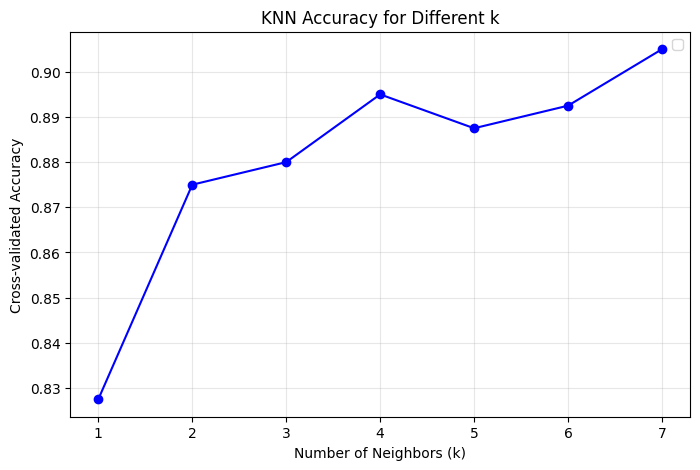

In [165]:
# Plot Accuracy over differetn k values
plt.figure(figsize=(8,5))
plt.plot(k_range, cv_scores, marker='o', color='blue')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-validated Accuracy')
plt.title('KNN Accuracy for Different k')
plt.legend()
plt.grid(True, alpha=0.3)

### d) Plot the confusion matrix and interpret the results.

In [166]:
# Student Code

CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  226
False Positives (FP): 14
False Negatives (FN): 24
True Positives (TP):  136

Overall Error Rate: 9.5%
Type I Error (False Positive Rate): 5.8%
Type II Error (False Negative Rate): 15.0%


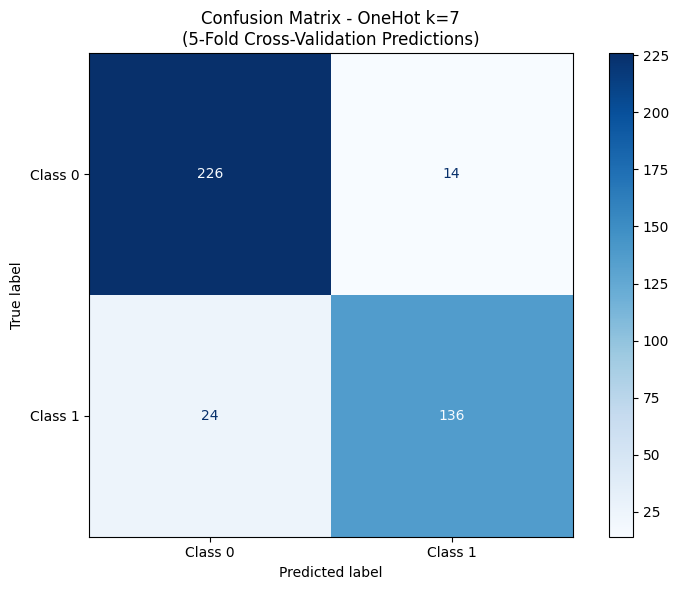

In [167]:
# Plot Confusion Matrix
evaluate_confusion_matrix(X, y, best_knn, model_name=best_model)

### e) Visualize the ROC curve

ROC-AUC PERFORMANCE
OneHot k=7:
  Cross-validation AUC: 0.929 (±0.032)
  ROC AUC: 0.926



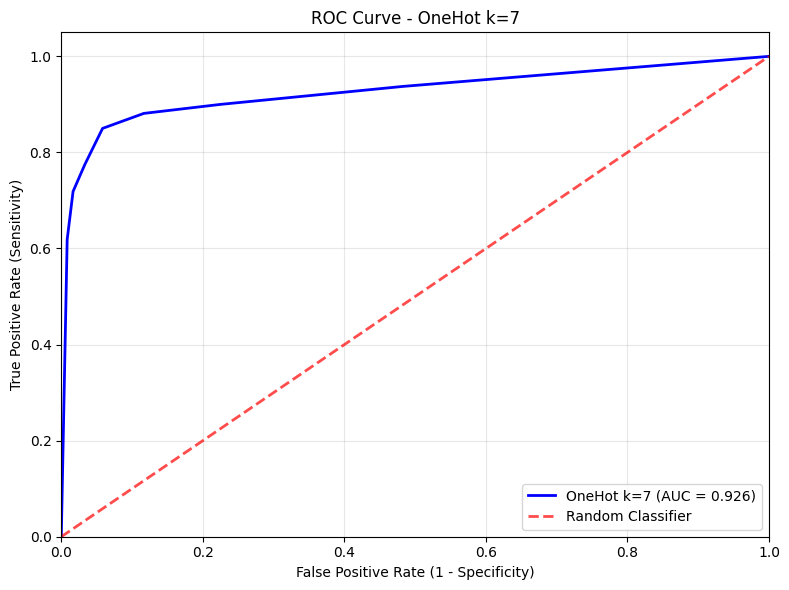

In [168]:
evaluate_roc(X, y, best_knn, model_name=best_model)

## 3. SVM

https://htmlpreview.github.io/?https://github.com/higgi13425/medicaldata/blob/master/man/description_docs/thiomon_desc.html

Maybe dataset is too big, it takes a long time to run


In [169]:
from sklearn.model_selection import GridSearchCV


### a) Load the dataset `sahd.csv` and explore it.
- What outcome do you want to predict?
- What predictors do you want to use?
- Do you have categorical variables?
- Do you have missing values?

In [170]:
# Student Code

In [171]:
# Solution
df = pd.read_csv('sahd.csv')

In [172]:
print(df.shape)
df.head()

(462, 8)


,chd,sbp,tobacco,ldl,famhist,obesity,alcohol,age
0,1,160,12.0000,5.7300,Present,25.3000,97.2000,52
1,1,144,0.0100,4.4100,Absent,28.8700,2.0600,63
2,0,118,0.0800,3.4800,Present,29.1400,3.8100,46
3,1,170,7.5000,6.4100,Present,31.9900,24.2600,58
4,1,134,13.6000,3.5000,Present,25.9900,57.3400,49


In [173]:
# Remove missing values
df = df.dropna()

In [174]:
# Check the features and outcomes
print("Features:")
print(df.columns.tolist())

Features:
['chd', 'sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']


In [175]:
# Check for categorical features and their values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   chd      462 non-null    int64  
 1   sbp      462 non-null    int64  
 2   tobacco  462 non-null    float64
 3   ldl      462 non-null    float64
 4   famhist  462 non-null    object 
 5   obesity  462 non-null    float64
 6   alcohol  462 non-null    float64
 7   age      462 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 29.0+ KB
None


In [176]:
# Prepare data for modeling
X = df.drop(columns=["chd"])
y = df["chd"]

### b) One-Hot Encode the categorical variables.

In [177]:
# Student Code

In [178]:
# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

### c) Perform SVM with C=1 and a linear kernel.
- Evaluate the model using cross-validation
- What accuracies do you get?

*Hint:* You can use the `SVC` class from `sklearn.svm` to perform SVM classification. And `cross_val_score` from `sklearn.model_selection` to evaluate the model using cross-validation.

In [179]:
# Student Code

In [180]:
# Perform SVM with C=1, linear kernel and cross validation
svm_model_initial = SVC(C=1, kernel='linear', random_state=42, probability=True)
scores = cross_val_score(svm_model_initial, X, y, cv=5, scoring='accuracy')
print(f"SVM Scores: {scores}")
print(f"SVM Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

SVM Scores: [0.72043011 0.7311828  0.66304348 0.72826087 0.76086957]
SVM Accuracy: 0.7208 ± 0.0320


### d) Perform a grid search 
Use C = [0.1, 0.5, 1] and kernel = [linear, radial].
- Use cross-validation
- What is the best combination of parameters?

*Hint:* You can use `GridSearchCV` from `sklearn.model_selection` to perform grid search.

In [181]:
# Grid search for SVM with different C and kernel

C = [0.1, 0.5, 1]
kernel = ['linear', 'rbf']

In [182]:
# Student Code

In [183]:
# Use sklearn's GridSearchCV
param_grid = {
    'C': C,
    'kernel': kernel
}   
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

results = pd.DataFrame(grid_search.cv_results_)[['param_C', 'param_kernel', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [184]:
# Group by kernel for better visibility
grouped = results.groupby('param_kernel')
for kernel_name, group in grouped:
    print(f"\nResults for kernel = '{kernel_name}':")
    print(group[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']].to_string(index=False))

# Best Model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_model_name = f'SVM C={best_params["C"]}, kernel={best_params["kernel"]}'
print(f"\nBest Model: {best_model_name}")


Results for kernel = 'linear':
 param_C  mean_test_score  std_test_score  rank_test_score
  0.1000           0.7272          0.0444                1
  0.5000           0.7208          0.0332                2
  1.0000           0.7208          0.0320                3

Results for kernel = 'rbf':
 param_C  mean_test_score  std_test_score  rank_test_score
  0.1000           0.6537          0.0018                4
  0.5000           0.6515          0.0054                5
  1.0000           0.6493          0.0067                6

Best Model: SVM C=0.1, kernel=linear


### d) Now perform SVM with the best parameters from the grid search.

In [185]:
# Student Code

In [186]:
# Perform SVM with C=0.1, linear kernel and cross validation
svm_model_optimized = SVC(C=0.1, kernel='linear', random_state=42, probability=True)
scores_optimized = cross_val_score(svm_model_optimized, X, y, cv=5, scoring='accuracy')
print(f"SVM Scores: {scores_optimized}")
print(f"SVM Accuracy: {scores_optimized.mean():.4f} ± {scores_optimized.std():.4f}")

SVM Scores: [0.74193548 0.7311828  0.64130435 0.76086957 0.76086957]
SVM Accuracy: 0.7272 ± 0.0444


### e) Plot the data using UMAP and color based on the predicted class.
- What do you observe?

In [187]:
# Student Code

In [188]:
# Reduce data with umap
umap = UMAP(n_components=2, random_state=42)
X_reduced = umap.fit_transform(X)


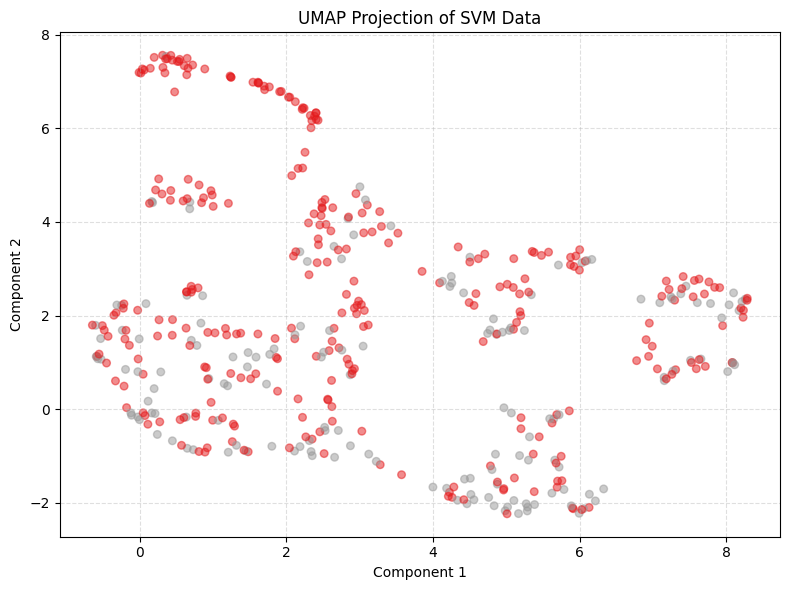

In [189]:
# Plot PCA results
plot_projection(X_reduced, y, title='UMAP Projection of SVM Data', 
                xlabel='Component 1', ylabel='Component 2',
                dataset_name='TODO Data')

Does not seem like the visualization works, maybe because dataset is not normalized or too big? Look at explained variance

### f) Plot the the confusion matrix of the initial params and the best params.
- What do you conclude?
- Which one performs better?

In [190]:
# Student Code

CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  253
False Positives (FP): 49
False Negatives (FN): 80
True Positives (TP):  80

Overall Error Rate: 27.9%
Type I Error (False Positive Rate): 16.2%
Type II Error (False Negative Rate): 50.0%
CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  257
False Positives (FP): 45
False Negatives (FN): 81
True Positives (TP):  79

Overall Error Rate: 27.3%
Type I Error (False Positive Rate): 14.9%
Type II Error (False Negative Rate): 50.6%


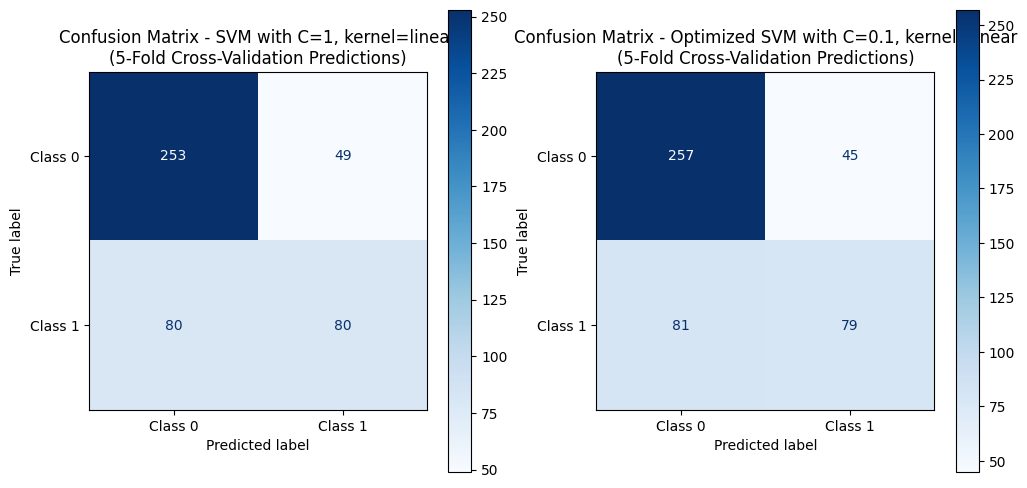

In [191]:
# Plot the two confusion matrices in one plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
evaluate_confusion_matrix(X, y, svm_model_initial, model_name="SVM with C=1, kernel=linear", ax=ax[0])
evaluate_confusion_matrix(X, y, svm_model_optimized, model_name="Optimized SVM with C=0.1, kernel=linear", ax=ax[1])

Again the dataset seems to be biased towards Class 0 outcomes (no heart disease). Also the difference is not that big between the two models

### f) Plot the ROC curve for both parameter combinations and report AUC.
- Does this plot support your conclusion?

In [192]:
# Student Code

ROC-AUC PERFORMANCE
SVM C=1, kernel=linear:
  Cross-validation AUC: 0.761 (±0.032)
  ROC AUC: 0.758

SVM C=0.1, kernel=linear:
  Cross-validation AUC: 0.763 (±0.036)
  ROC AUC: 0.762



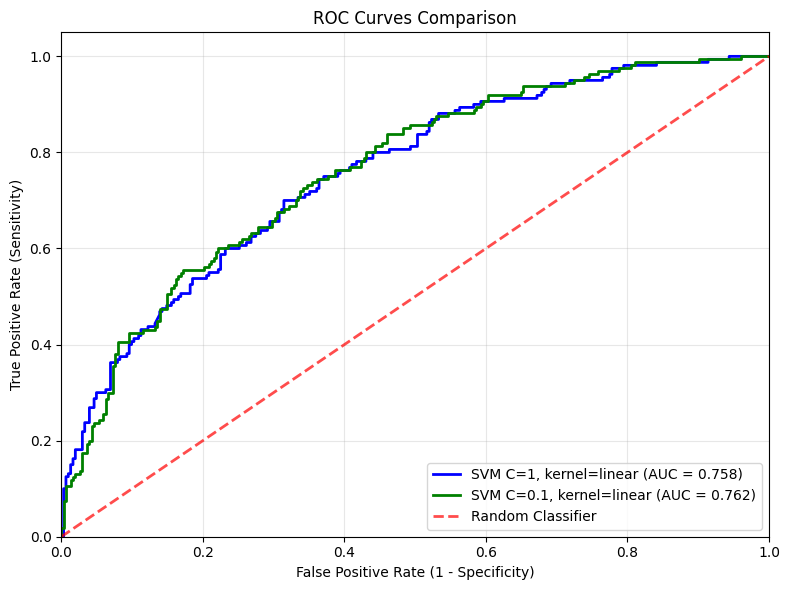

In [193]:
# Solution
evaluate_roc(X, y, models=[svm_model_initial, best_model], model_names=["SVM C=1, kernel=linear", best_model_name])

## 4. Classification Overview

### a) Load and explore the dataset `thiomon.csv`.
- What variables do you have? 
- Do you have categorical variables?

In [194]:
# Student Code

In [195]:
# Solution
df = pd.read_csv("thiomon.csv")#pd.read_csv("sahd.csv")

df = df.dropna()

In [196]:
print(df.shape)
df.iloc[:,:5].head()

(5059, 31)


,days_of_life,wbc,hgb,hct,plt
0,27543.0000,12.1000,13.1000,37.7000,110.0000
1,27543.0000,12.6000,13.3000,38.4000,116.0000
2,27544.0000,11.4000,13.4000,39.5000,119.0000
3,27545.0000,11.5000,13.3000,39.3000,124.0000
4,27546.0000,7.1000,12.4000,35.9000,118.0000


In [197]:
# Check the features and outcomes
print("Features:")
print(df.columns.tolist()[:5])

Features:
['days_of_life', 'wbc', 'hgb', 'hct', 'plt']


In [198]:
# Check for categorical features and their values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5059 entries, 0 to 5058
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   days_of_life   5059 non-null   float64
 1   wbc            5059 non-null   float64
 2   hgb            5059 non-null   float64
 3   hct            5059 non-null   float64
 4   plt            5059 non-null   float64
 5   rbc            5059 non-null   float64
 6   mcv            5059 non-null   float64
 7   mch            5059 non-null   float64
 8   mchc           5059 non-null   float64
 9   rdw            5059 non-null   float64
 10  mpv            5059 non-null   float64
 11  neut_percent   5059 non-null   float64
 12  lymph_percent  5059 non-null   float64
 13  mono_percent   5059 non-null   float64
 14  eos_percent    5059 non-null   float64
 15  baso_percent   5059 non-null   float64
 16  sod            5059 non-null   int64  
 17  pot            5059 non-null   float64
 18  chlor   

In [199]:
# Get unique values for categorical features
for col in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in {col}: {df[col].unique()}")

In [200]:
print("Target variable distribution:")
print(df['remission'].value_counts())

Target variable distribution:
remission
1    2757
0    2302
Name: count, dtype: int64


In [201]:
# Prepare data for modeling
X = df.drop(columns=["remission"])
y = df["remission"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

### b) Perform standard logistic, Ridge logistic regression and Lasso logistic regression.
- What are the optimal alphas for ridge and lasso regression?
- Use cross-validation and report accuracy per fold for all three models.

*Hint:* you can use `RidgeClassifierCV` for Ridge logistic regression and `LogisticRegressionCV(penalty='l1', solver='liblinear', random_state=42, cv=3, max_iter=1000, n_jobs=-1)` for Lasso logistic regression.


In [202]:
# Student Code

In [203]:
# Perform logistic regression with cross validation
log_reg = LogisticRegression(random_state=42)
lr_scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')
log_reg.fit(X, y);

In [204]:
# Perform Ridge regression with cross validation
alphas = np.logspace(-3, 3, 10)
ridge_model = RidgeClassifierCV(alphas=alphas, scoring='accuracy', store_cv_results=True)
ridge_model = ridge_model.fit(X, y)

print("Optimal alpha for Ridge Regression:", ridge_model.alpha_)

ridge_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='accuracy')

Optimal alpha for Ridge Regression: 0.001


In [205]:
# Perform Lasso regression with cross validation
from sklearn.linear_model import LogisticRegressionCV
Cs = np.logspace(-3, 3, 10)
lasso_model = LogisticRegressionCV(Cs=Cs, penalty='l1', solver='liblinear', random_state=42, cv=3, max_iter=1000, n_jobs=-1)
lasso_model.fit(X, y)
print("Optimal alpha for Lasso Regression:", 1/lasso_model.C_)

lasso_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='accuracy')

Optimal alpha for Lasso Regression: [46.41588834]


In [206]:
# Put scores in a dataframe and print
results_df = pd.DataFrame({
    'Logistic Regression': lr_scores,
    'Ridge Regression': ridge_scores,
    'Lasso Regression': lasso_scores
})

# Format to show only 4 digits after the decimal point
results_df.index.name = 'Fold'
print(results_df)


      Logistic Regression  Ridge Regression  Lasso Regression
Fold                                                         
0                  0.6680            0.7045            0.7144
1                  0.6868            0.7213            0.7194
2                  0.6462            0.6630            0.6660
3                  0.6117            0.6107            0.6215
4                  0.6004            0.6182            0.6044


### c) Compare the 3 models using Accuracy and ROC.
- Average the values over the folds.
- Which model performs best?

In [207]:
# Student Code

In [208]:
# Print Accuracies
print(f"Logistic Regression Accuracy: {lr_scores.mean():.4f} ± {lr_scores.std():.4f}")
print(f"Ridge Regression Accuracy: {ridge_scores.mean():.4f} ± {ridge_scores.std():.4f}")
print(f"Lasso Regression Accuracy: {lasso_scores.mean():.4f} ± {lasso_scores.std():.4f}")

Logistic Regression Accuracy: 0.6426 ± 0.0327
Ridge Regression Accuracy: 0.6636 ± 0.0444
Lasso Regression Accuracy: 0.6651 ± 0.0468


ROC-AUC PERFORMANCE
Logistic Regression:
  Cross-validation AUC: 0.687 (±0.055)
  ROC AUC: 0.681

Ridge Regression:
  Cross-validation AUC: 0.704 (±0.060)
  ROC AUC: 0.704

Lasso Regression:
  Cross-validation AUC: 0.704 (±0.065)
  ROC AUC: 0.704



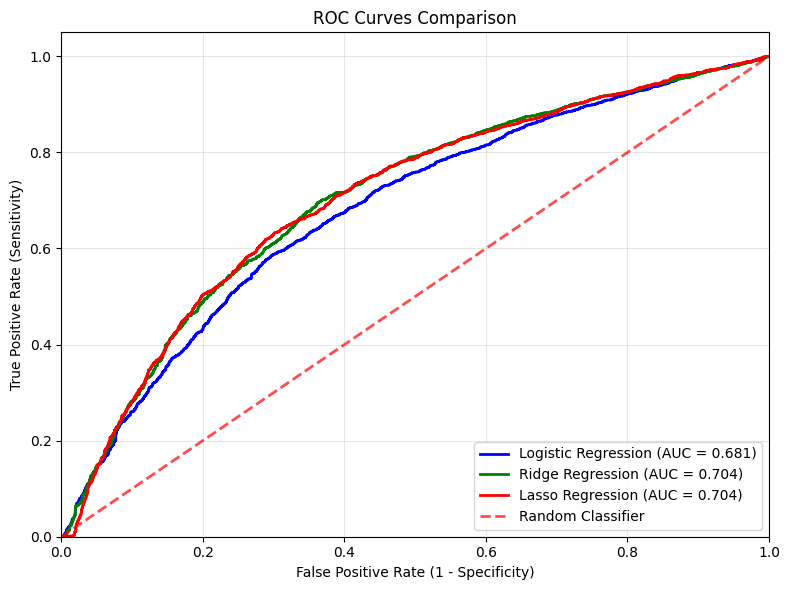

In [209]:
evaluate_roc(X, y, models=[log_reg, ridge_model, lasso_model], model_names=["Logistic Regression", "Ridge Regression", "Lasso Regression"])  

### d) Fit a random forest and report the accuracy and confusion matrix.
- How does it compare to the other models?

In [210]:
# Student Code

In [211]:
# Fit a random forest
rf_model = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
rf_model.fit(X, y);

In [212]:
# Report Accuracy
print(f"Random Forest Accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

Random Forest Accuracy: 0.6280 ± 0.0547


CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  1150
False Positives (FP): 1152
False Negatives (FN): 730
True Positives (TP):  2027

Overall Error Rate: 37.2%
Type I Error (False Positive Rate): 50.0%
Type II Error (False Negative Rate): 26.5%


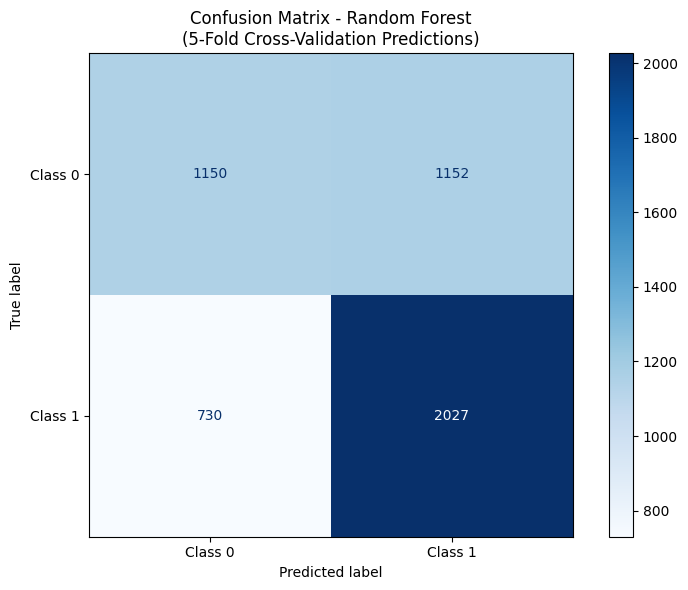

In [213]:
# Confusion Matrix
evaluate_confusion_matrix(X, y, rf_model, model_name="Random Forest")

In [214]:
# ROC
#evaluate_roc(X, y, rf_model, model_name="Random Forest")

### e) Fit a KNN model and report the accuracy and Confusion Matrix.
- Use *k*=5

In [215]:
# Student Code

In [216]:
# Fit a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')

In [217]:
# Report Accuracy
print(f"Random Forest Accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

Random Forest Accuracy: 0.6280 ± 0.0547


CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  914
False Positives (FP): 1388
False Negatives (FN): 1315
True Positives (TP):  1442

Overall Error Rate: 53.4%
Type I Error (False Positive Rate): 60.3%
Type II Error (False Negative Rate): 47.7%


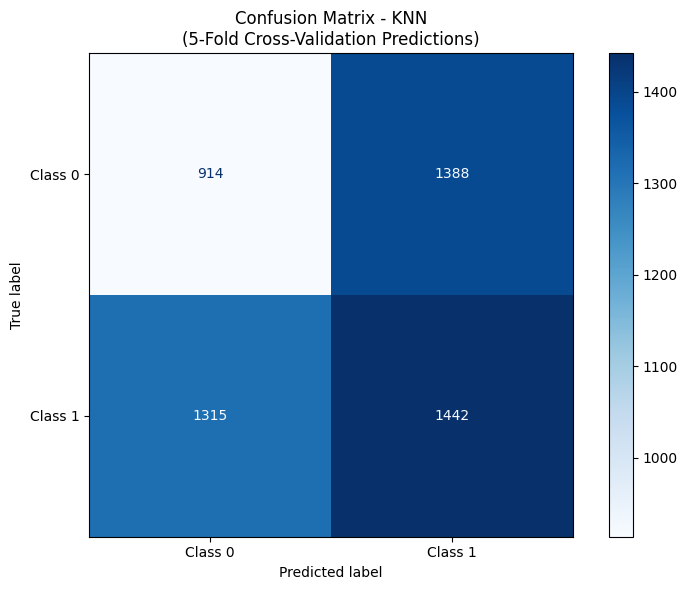

In [218]:
# Report Confusion Matrix
evaluate_confusion_matrix(X, y, knn_model, model_name="KNN")

In [219]:
# Report ROC
#evaluate_roc(X, y, knn_model, model_name="KNN")

### f) Fit a SVM model and report the accuracy and confusion matrix.
- Use C=1 and a linear kernel

In [220]:
# Student Code

In [ ]:
# Fit SVM
# I guess the dataset is too big, because svc takes forever
svm_model = SVC(C=0.1, kernel='linear', random_state=42, max_iter=1000, probability=True)
svm_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
svm_model.fit(X, y);

In [ ]:
# Report Accuracy
print(f"SVM Accuracy: {svm_scores.mean():.4f} ± {svm_scores.std():.4f}")

In [ ]:
# Report Confusion Matrix
evaluate_confusion_matrix(X, y, svm_model, model_name="SVM")

In [ ]:
# Report ROC
#evaluate_roc(X, y, svm_model, model_name="SVM")

### g) Compare accuracy and ROC of all models.
- Which model performs best?

In [ ]:
# Student Code

In [ ]:
# Put all mean and std accuracies in a dataframe
results_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'KNN', 'SVM'],
    'Mean Accuracy': [
        lr_scores.mean(),
        ridge_scores.mean(),
        lasso_scores.mean(),
        rf_scores.mean(),
        knn_scores.mean(),
        svm_scores.mean()
    ],
    'Std Accuracy': [
        lr_scores.std(),
        ridge_scores.std(),
        lasso_scores.std(),
        rf_scores.std(),
        knn_scores.std(),
        svm_scores.std()
    ]
})
results_summary.set_index('Model', inplace=True)

print(results_summary)

In [ ]:
# ROC of all models
models = [log_reg, ridge_model, rf_model, knn_model, svm_model]
model_names = ["Logistic Regression", "Ridge Regression", "Random Forest", "KNN", "SVM"]
evaluate_roc(X, y, models=models, model_names=model_names)

### h) Extract coefficients of logistic, ridge and lasso 
- Which features are most important?

In [ ]:
# Student Code

In [ ]:
# Plot coefficients for logistic regression, ridge and lasso classification
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
# maybe add this function to the handson
coef_feature_importance(X, log_reg, title='Logistic Regression Feature Importance', ax=ax[0])
coef_feature_importance(X, ridge_model, title='Ridge Classification Feature Importance', ax=ax[1])
coef_feature_importance(X, lasso_model, title='Lasso Classification Feature Importance', ax=ax[2])

### i) Extract feature importance from the random forest model.
- Which features are most important?

In [ ]:
# Student Code

In [ ]:
# Plot feature importance for random forest
simple_feature_importance(X, rf_model, title='Random Forest Feature Importance')

### j) Extract feature importance from the SVM model.

*Hint:* You can use `coef_feature_importance` from the helper file to visualize the feature importance of a linear SVM model.

In [ ]:
# Student Code

In [ ]:
# SVM Feature Importance
coef_feature_importance(X, svm_model, title='SVM Feature Importance')

### k) Compare the feature importance of all models.
- Are the most important features consistent across models?

#### Your Answer:

#### Solution:
Once Dataset fixed

### l) Reflect on interpretability of the models.
- Which models provide interpretability? Which don't?

#### Your Answer:

#### Solution:
Models ordered from most to least interpretable:
- Logistic Regression: Direct probabilistic interpretation
- Linear SVM: Direct coefficient interpretation (same level as logistic)
- Ridge/Lasso Regression: Same as above but regularized
- Random Forest: Feature importance available, but complex interactions
- KNN: Instance-based, no global model to interpret

### m) Optional: Find optimal parameters for KNN and SVM and compare accuracies again

In [ ]:
# Parameter values:
k_range = range(1, 8)
C_values = [0.1, 0.5, 1]
kernels = ['linear', 'rbf']

In [ ]:
# Student Code

In [ ]:
# Optimize KNN
from sklearn.model_selection import GridSearchCV
param_grid_knn = {'n_neighbors': k_range}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
knn_grid_search.fit(X, y)
# Print best parameters and score
print(f"Best KNN parameters: {knn_grid_search.best_params_}")
print(f"Best KNN score: {knn_grid_search.best_score_:.4f}")
print(f"Old KNN score: {knn_scores.mean():.4f}")
print(f"Improvement: {knn_grid_search.best_score_ - knn_scores.mean():.4f}")


In [ ]:
# Optimize SVM
param_grid_svm = {
    'C': C_values,
    'kernel': kernels
}
grid_search = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_search.fit(X, y)
# Print best parameters and score
print(f"Best SVM parameters: {grid_search.best_params_}")
print(f"Best SVM score: {grid_search.best_score_:.4f}")
print(f"Old SVM score: {svm_scores.mean():.4f}")
print(f"Improvement: {grid_search.best_score_ - svm_scores.mean():.4f}")